<a href="https://colab.research.google.com/github/HwangHanJae/ml-definitive-guide-pratice/blob/main/classification/xgb_lightgbm_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 캐글 산탄데르 고객 만족 예측  
##(Kaggle Santander Customer Satisfaction)

370개의 피처로 주어진 데이터 세트에 기반하여 고객 만족 여부를 예측하는 것  
피처는 모두 익명처리 되어 있고, 클래스 레이블 명은 TARGET으로 '1'이면 불만 '0'이면 만족  
모델의 성능 평가는 ROC-AUC로 평가


##데이터 로드 및 전처리

In [39]:
train_path = "/content/drive/MyDrive/Colab Notebooks/DataScience/Data/santander-customer-satisfaction/train.csv"
test_path ="/content/drive/MyDrive/Colab Notebooks/DataScience/Data/santander-customer-satisfaction/test.csv"
sub_path = "/content/drive/MyDrive/Colab Notebooks/DataScience/Data/santander-customer-satisfaction/sample_submission.csv"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mlp

train = pd.read_csv(train_path, encoding='latin-1')
test = pd.read_csv(test_path,encoding='latin-1')
sub = pd.read_csv(sub_path,encoding='latin-1')

display(train.head())
print("train shape", train.shape)

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var1,ind_var2_0,ind_var2,ind_var5_0,ind_var5,ind_var6_0,ind_var6,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13_medio_0,ind_var13_medio,ind_var13,...,saldo_medio_var5_ult1,saldo_medio_var5_ult3,saldo_medio_var8_hace2,saldo_medio_var8_hace3,saldo_medio_var8_ult1,saldo_medio_var8_ult3,saldo_medio_var12_hace2,saldo_medio_var12_hace3,saldo_medio_var12_ult1,saldo_medio_var12_ult3,saldo_medio_var13_corto_hace2,saldo_medio_var13_corto_hace3,saldo_medio_var13_corto_ult1,saldo_medio_var13_corto_ult3,saldo_medio_var13_largo_hace2,saldo_medio_var13_largo_hace3,saldo_medio_var13_largo_ult1,saldo_medio_var13_largo_ult3,saldo_medio_var13_medio_hace2,saldo_medio_var13_medio_hace3,saldo_medio_var13_medio_ult1,saldo_medio_var13_medio_ult3,saldo_medio_var17_hace2,saldo_medio_var17_hace3,saldo_medio_var17_ult1,saldo_medio_var17_ult3,saldo_medio_var29_hace2,saldo_medio_var29_hace3,saldo_medio_var29_ult1,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,300.0,122.22,300.0,240.75,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3.00,2.07,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,0.0,195.0,195.0,0.0,0.0,195.0,0.0,0.0,195.0,0.0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,91.56,138.84,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,...,40501.08,13501.47,0.0,0.0,0.0,0.0,0.0,0.0,85501.89,85501.89,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


train shape (76020, 371)


피처가 371개 존재함

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


111개의 피처가 float64, 260개의 피처가 int64로 모두 숫자형임  
NULL값은 없음  

In [22]:
print(train["TARGET"].value_counts())
ratio = (train.loc[train["TARGET"] == 1, "TARGET"].count())/(train["TARGET"].count())
print(f"불만족 비율 : {np.round(ratio, 3) * 100}%")

0    73012
1     3008
Name: TARGET, dtype: int64
불만족 비율 : 4.0%


만족비율이 96%, 불만족은 4%로 나타남

In [23]:
train.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var1,ind_var2_0,ind_var2,ind_var5_0,ind_var5,ind_var6_0,ind_var6,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13_medio_0,ind_var13_medio,ind_var13,...,saldo_medio_var5_ult1,saldo_medio_var5_ult3,saldo_medio_var8_hace2,saldo_medio_var8_hace3,saldo_medio_var8_ult1,saldo_medio_var8_ult3,saldo_medio_var12_hace2,saldo_medio_var12_hace3,saldo_medio_var12_ult1,saldo_medio_var12_ult3,saldo_medio_var13_corto_hace2,saldo_medio_var13_corto_hace3,saldo_medio_var13_corto_ult1,saldo_medio_var13_corto_ult3,saldo_medio_var13_largo_hace2,saldo_medio_var13_largo_hace3,saldo_medio_var13_largo_ult1,saldo_medio_var13_largo_ult3,saldo_medio_var13_medio_hace2,saldo_medio_var13_medio_hace3,saldo_medio_var13_medio_ult1,saldo_medio_var13_medio_ult3,saldo_medio_var17_hace2,saldo_medio_var17_hace3,saldo_medio_var17_ult1,saldo_medio_var17_ult3,saldo_medio_var29_hace2,saldo_medio_var29_hace3,saldo_medio_var29_ult1,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.0,76020.0,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000,7.602000e+04,7.602000e+04,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,7.602000e+04,76020.000000,76020.0,76020.000000,76020.000000,7.602000e+04,7.602000e+04,7.602000e+04,7.602000e+04,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,3.160715,68.803937,113.056934,68.205140,113.225058,137.242763,68.618087,113.792410,140.403479,5.477676,0.011458,0.003762,0.0,0.0,0.958024,0.663760,0.000105,0.000026,0.032833,0.028598,0.067522,0.045462,0.052249,0.042936,0.041476,0.010168,0.009997,0.000026,0.000026,0.050855,...,1077.256756,1048.856447,68.275452,9.505287,124.620962,110.026575,3.997023e+03,613.534443,5.703008e+03,4.401002e+03,3639.419939,556.184178,4852.261814,3857.848542,771.227449,162.170439,9.569502e+02,7.509563e+02,0.175324,0.0,0.513023,0.344174,9.117181e+01,3.646318e+01,1.310316e+02,1.092169e+02,0.213071,0.001910,0.253907,0.186630,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,95.268204,319.605516,512.154823,531.897917,950.086398,697.712596,535.473750,953.578624,712.767240,465.391149,0.106425,0.061221,0.0,0.0,0.200535,0.472425,0.010258,0.005129,0.178202,0.166674,0.250925,0.208316,0.222531,0.202714,0.199390,0.100325,0.099486,0.005129,0.005129,0.219703,...,9614.906985,8189.948852,1733.838226,519.389157,2205.249804,1935.305713,3.777314e+04,9292.752726,4.620254e+04,3.550718e+04,26359.174223,7182

피처의 분포를 확인해보면  
var3 컬럼의 경우 min 값이 -999999인 경우가 있음  
이는 NULL값이나 특정 예외값을 표현했을 것임  


In [35]:
train.loc[train['var3'] < 0,"var3"] = 2

해당 값은 가장 분포가 많은 2로 변경을 해주었음

In [42]:
drop_col = ["ID"]
def drop_feature(df, drop_col):
  df = df.drop(drop_col, axis=1)
  print(f"{drop_col}를 삭제 하였음")
  return df

def data_preprocessing(df, drop_col):
  df = drop_feature(df, drop_col)
  df.loc[df['var3'] < 0, 'var3'] = 2
  return df
train = data_preprocessing(train, drop_col)
test = data_preprocessing(test, drop_col)

['ID']를 삭제 하였음
['ID']를 삭제 하였음


불필요한 ID값을 삭제하고 위에서 변경해주었던 작업을 함수로 바꾸고 적용함

In [46]:
X = train.drop("TARGET", axis=1)
y = train["TARGET"]

print("훈련데이터 : {}".format(X.shape))
print("타겟 : {}".format(y.shape))

훈련데이터 : (76020, 369)
타겟 : (76020,)


훈련데이터와 타겟데이터를 분리

In [47]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
print(f"학습 데이터 세트 Shape : {X_train.shape}, 검증 데이터 세트 Shape {X_val.shape}, 테스트 데이터 세트 Shape {X_test.shape}")
print("학습 레이블 값 분포 비율")
print(y_train.value_counts()/ y_train.count())
print("\n")
print("검증 레이블 값 분포 비율")
print(y_val.value_counts()/ y_val.count())
print("\n")
print("테스트 레이블 값 분포 비율")
print(y_test.value_counts()/ y_test.count())

학습 데이터 세트 Shape : (48652, 369), 검증 데이터 세트 Shape (12164, 369), 테스트 데이터 세트 Shape (15204, 369)
학습 레이블 값 분포 비율
0    0.960906
1    0.039094
Name: TARGET, dtype: float64


검증 레이블 값 분포 비율
0    0.961197
1    0.038803
Name: TARGET, dtype: float64


테스트 레이블 값 분포 비율
0    0.9583
1    0.0417
Name: TARGET, dtype: float64


학습/검증/테스트 데이터 세트로 분리하였고, 모두 불만족이 4% 비율을 나타냈음

## 모델학습

In [49]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score

xgb = XGBClassifier()
light = LGBMClassifier()
models = [xgb, light]
for model in models:
  model.fit(X_train, y_train, eval_metric='auc')
  predict_proba = model.predict_proba(X_val)[:,1]
  roc_auc = roc_auc_score(y_val, predict_proba, average='macro')
  print(f"{model.__class__.__name__}")
  print(f"ROC AUC : {np.round(roc_auc,4)}")

XGBClassifier
ROC AUC : 0.8389
LGBMClassifier
ROC AUC : 0.8369


하이퍼 파라미터를 따로 지정하지 않고 가장 기본적인 모델로 학습을 진행하였음  
XGBoost와 LightGBM 둘다 약 83%정도를 보이고 있음

In [53]:
xgb = XGBClassifier(n_estimators=500, random_state=156,n_jobs=-1)
light = LGBMClassifier(n_estimators=500,random_state=156,n_jobs=-1)

#성능평가지표를 auc로, 조기중단을 100으로 설정하고 학습 수행
xgb.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='auc', eval_set=[(X_train, y_train), (X_val, y_val)])
xgb_predict_proba = xgb.predict_proba(X_val)[:,1]
xgb_roc_auc = roc_auc_score(y_val, xgb_predict_proba, average='macro')
print(xgb.__class__.__name__)
print(f"ROC AUC : {np.round(xgb_roc_auc,4)}")


#성능평가지표를 auc로, 조기중단을 100으로 설정하고 학습 수행
light.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='auc', eval_set=[(X_val, y_val)])
light_predict_proba = light.predict_proba(X_val)[:,1]
light_roc_auc = roc_auc_score(y_val, light_predict_proba, average='macro')


print(xgb.__class__.__name__)
print(f"ROC AUC : {np.round(xgb_roc_auc,4)}")
print(light.__class__.__name__)
print(f"ROC AUC : {np.round(light_roc_auc,4)}")

[0]	validation_0-auc:0.80084	validation_1-auc:0.79781
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.803439	validation_1-auc:0.790469
[2]	validation_0-auc:0.803918	validation_1-auc:0.790217
[3]	validation_0-auc:0.809281	validation_1-auc:0.801559
[4]	validation_0-auc:0.813024	validation_1-auc:0.80037
[5]	validation_0-auc:0.813577	validation_1-auc:0.800024
[6]	validation_0-auc:0.815991	validation_1-auc:0.804695
[7]	validation_0-auc:0.816883	validation_1-auc:0.805133
[8]	validation_0-auc:0.817721	validation_1-auc:0.805971
[9]	validation_0-auc:0.817631	validation_1-auc:0.805803
[10]	validation_0-auc:0.818252	validation_1-auc:0.805907
[11]	validation_0-auc:0.81837	validation_1-auc:0.805992
[12]	validation_0-auc:0.822329	validation_1-auc:0.813108
[13]	validation_0-auc:0.822481	validation_1-auc:0.813634
[14]	validation_0-auc:0.821607	validation_1-auc:0.813007
[

두 모델다 84%로 증가 한것을 볼 수 있음

## 하이퍼 파라미터 튜닝

### XGBClassifier

In [59]:
from sklearn.model_selection import GridSearchCV

#하이퍼 파라미터 테스트의 수행 속도를 높이기 위하여 n_estimators = 100으로 감소
xgb_clf = XGBClassifier(n_estimators=100, random_state=156,n_jobs=-1)

params = {
    "max_depth" : [5,7],
    "min_child_weight" : [1,3],
    "colsample_bytree" : [0.5, 0.75]
}

#하이퍼 파라미터 테스트의 수행속도를 향상시키기 위해 cv를 지정하지 않음
gridcv = GridSearchCV(xgb_clf, param_grid=params, n_jobs=-1)
gridcv.fit(X_train, y_train, early_stopping_rounds=30, eval_metric='auc', eval_set = [(X_train, y_train), (X_val, y_val)])
print("GridSearchCV 최적 파라미터 : ",gridcv.best_params_)

xgb_val_predict_proba = gridcv.predict_proba(X_val)[:,1]
xgb_val_auc_score = roc_auc_score(y_val, xgb_val_predict_proba, average='macro')
print(f"Validation 세트의 ROC AUC : {np.round(xgb_val_auc_score,4)}")

xgb_test_predict_proba = gridcv.predict_proba(X_test)[:,1]
xgb_test_auc_score = roc_auc_score(y_test, xgb_test_predict_proba, average='macro')
print(f"Test 세트의 ROC AUC : {np.round(xgb_test_auc_score,4)}")

Validation 세트의 ROC AUC : 0.8385
Test 세트의 ROC AUC : 0.8459


최적 하이퍼 파라미터는 'colsample_bytree': 0.5, 'max_depth': 5, 'min_child_weight': 1 이다.  

테스트 세트 결과 0.845를 기대할 수 있다.

In [60]:
#n_estimators =1000으로 증가, learning_rate=0.02로 감소, reg_alpha = 0.03으로 추가
xgb_clf = XGBClassifier(n_estimators=1000,learning_rate = 0.02, reg_alpha=0.03,colsample_bytree = 0.5, max_depth = 5, min_child_weight = 1, random_state=156,n_jobs=-1)

#조기중단을 200으로 설정
xgb_clf.fit(X_train, y_train, early_stopping_rounds=200,eval_metric='auc', eval_set = [(X_train, y_train), (X_val, y_val)])

xgb_val_predict_proba = xgb_clf.predict_proba(X_val)[:,1]
xgb_val_auc_score = roc_auc_score(y_val, xgb_val_predict_proba, average='macro')
print(f"Validation 세트의 ROC AUC : {np.round(xgb_val_auc_score,4)}")

xgb_test_predict_proba = xgb_clf.predict_proba(X_test)[:,1]
xgb_test_auc_score = roc_auc_score(y_test, xgb_test_predict_proba, average='macro')
print(f"Validation 세트의 ROC AUC : {np.round(xgb_test_auc_score,4)}")

[0]	validation_0-auc:0.813836	validation_1-auc:0.805212
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 200 rounds.
[1]	validation_0-auc:0.821477	validation_1-auc:0.810124
[2]	validation_0-auc:0.820727	validation_1-auc:0.806878
[3]	validation_0-auc:0.823295	validation_1-auc:0.810609
[4]	validation_0-auc:0.826994	validation_1-auc:0.813684
[5]	validation_0-auc:0.820418	validation_1-auc:0.802206
[6]	validation_0-auc:0.826259	validation_1-auc:0.809261
[7]	validation_0-auc:0.826628	validation_1-auc:0.809508
[8]	validation_0-auc:0.833608	validation_1-auc:0.817513
[9]	validation_0-auc:0.833988	validation_1-auc:0.818664
[10]	validation_0-auc:0.832767	validation_1-auc:0.81686
[11]	validation_0-auc:0.831158	validation_1-auc:0.814501
[12]	validation_0-auc:0.828859	validation_1-auc:0.813554
[13]	validation_0-auc:0.830497	validation_1-auc:0.814287
[14]	validation_0-auc:0.832797	validation_1-auc:0.81520

roc suc 점수가 약간 증가한 것을 볼 수 있다.

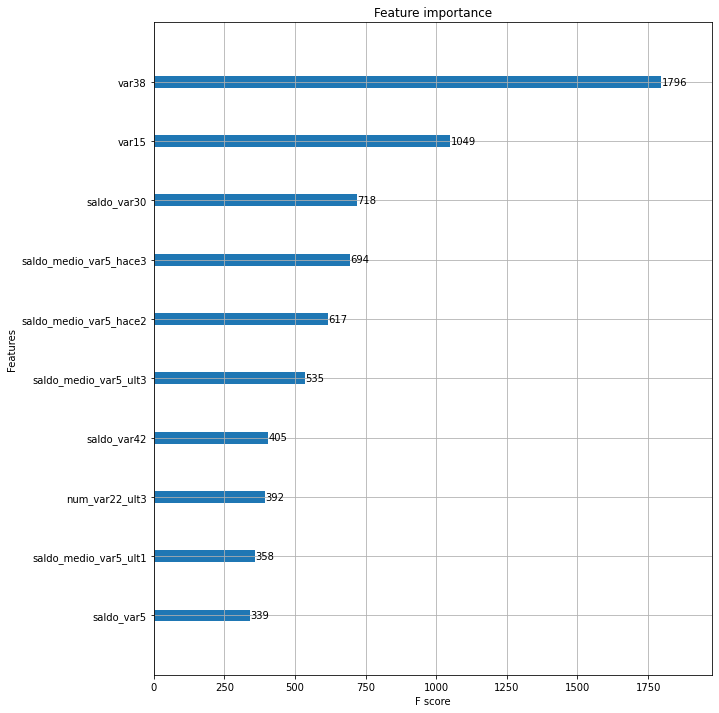

In [61]:
from xgboost import plot_importance

fig, ax = plt.subplots(figsize=(10,12))
plot_importance(xgb_clf, ax=ax, max_num_features=10)

xgboost에서의 피처의 중요도 Top10이다.  
xgboost는 var38 -> var15 순으로 중요하다고 판단하였다.

In [69]:
#제출
#y_test = 0.8467, y_val = 0.8398
pred = xgb_clf.predict(test)

sub["TARGET"] = pred
sub.to_csv("xgboost_test_score_is_0.8467.csv", index=False)

### LightGBM

In [70]:
from sklearn.model_selection import GridSearchCV

#하이퍼 파라미터 테스트의 수행 속도를 높이기 위하여 n_estimators = 100으로 감소
light_clf = LGBMClassifier(n_estimators=200, random_state=156,n_jobs=-1)

params = {
    "num_leaves" : [32,64],
    "max_depth" : [128,160],
    "min_child_samples" : [60, 100],
    "subsample" : [0.8,1]
}

#하이퍼 파라미터 테스트의 수행속도를 향상시키기 위해 cv를 지정하지 않음
gridcv = GridSearchCV(light_clf, param_grid=params, n_jobs=-1)
gridcv.fit(X_train, y_train, early_stopping_rounds=30, eval_metric='auc', eval_set = [(X_train, y_train), (X_val, y_val)])
print("GridSearchCV 최적 파라미터 : ",gridcv.best_params_)

light_val_predict_proba = gridcv.predict_proba(X_val)[:,1]
light_val_auc_score = roc_auc_score(y_val, light_val_predict_proba, average='macro')
print(f"Validation 세트의 ROC AUC : {np.round(light_val_auc_score,4)}")

light_test_predict_proba = gridcv.predict_proba(X_test)[:,1]
light_test_auc_score = roc_auc_score(y_test, light_test_predict_proba, average='macro')
print(f"Test 세트의 ROC AUC : {np.round(light_test_auc_score,4)}")

[1]	training's auc: 0.838535	training's binary_logloss: 0.155397	valid_1's auc: 0.816248	valid_1's binary_logloss: 0.156493
Training until validation scores don't improve for 30 rounds.
[2]	training's auc: 0.849465	training's binary_logloss: 0.149707	valid_1's auc: 0.823368	valid_1's binary_logloss: 0.151808
[3]	training's auc: 0.856446	training's binary_logloss: 0.145442	valid_1's auc: 0.826183	valid_1's binary_logloss: 0.148506
[4]	training's auc: 0.860725	training's binary_logloss: 0.141981	valid_1's auc: 0.826569	valid_1's binary_logloss: 0.145961
[5]	training's auc: 0.865046	training's binary_logloss: 0.139173	valid_1's auc: 0.829279	valid_1's binary_logloss: 0.143807
[6]	training's auc: 0.867346	training's binary_logloss: 0.136814	valid_1's auc: 0.831468	valid_1's binary_logloss: 0.142098
[7]	training's auc: 0.869084	training's binary_logloss: 0.134846	valid_1's auc: 0.831527	valid_1's binary_logloss: 0.140782
[8]	training's auc: 0.871551	training's binary_logloss: 0.133021	valid

GridSearchCV 최적 파라미터 :  {'max_depth': 128, 'min_child_samples': 100, 'num_leaves': 64, 'subsample': 0.8}  
Validation 세트의 ROC AUC : 0.8356  
Test 세트의 ROC AUC : 0.8404  


In [71]:
light_clf = LGBMClassifier(n_estimators=1000,max_depth=128,min_child_samples=100, num_leaves=64, subsample=0.8, random_state=156,n_jobs=-1)

#조기중단을 100으로 설정
light_clf.fit(X_train, y_train, early_stopping_rounds=100,eval_metric='auc', eval_set = [(X_val, y_val)])

light_val_predict_proba = gridcv.predict_proba(X_val)[:,1]
light_val_auc_score = roc_auc_score(y_val, light_val_predict_proba, average='macro')
print(f"Validation 세트의 ROC AUC : {np.round(light_val_auc_score,4)}")

light_test_predict_proba = gridcv.predict_proba(X_test)[:,1]
light_test_auc_score = roc_auc_score(y_test, light_test_predict_proba, average='macro')
print(f"Test 세트의 ROC AUC : {np.round(light_test_auc_score,4)}")

[1]	valid_0's auc: 0.816248	valid_0's binary_logloss: 0.156493
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.823368	valid_0's binary_logloss: 0.151808
[3]	valid_0's auc: 0.826183	valid_0's binary_logloss: 0.148506
[4]	valid_0's auc: 0.826569	valid_0's binary_logloss: 0.145961
[5]	valid_0's auc: 0.829279	valid_0's binary_logloss: 0.143807
[6]	valid_0's auc: 0.831468	valid_0's binary_logloss: 0.142098
[7]	valid_0's auc: 0.831527	valid_0's binary_logloss: 0.140782
[8]	valid_0's auc: 0.831687	valid_0's binary_logloss: 0.139658
[9]	valid_0's auc: 0.832229	valid_0's binary_logloss: 0.138652
[10]	valid_0's auc: 0.831921	valid_0's binary_logloss: 0.137889
[11]	valid_0's auc: 0.832142	valid_0's binary_logloss: 0.137302
[12]	valid_0's auc: 0.83185	valid_0's binary_logloss: 0.136776
[13]	valid_0's auc: 0.832958	valid_0's binary_logloss: 0.136282
[14]	valid_0's auc: 0.83321	valid_0's binary_logloss: 0.135793
[15]	valid_0's auc: 0.833268	valid_0's binary_loglos

In [72]:
#제출
#y_test = 8404, y_val = 0.8356
pred = light_clf.predict(test)

sub["TARGET"] = pred
sub.to_csv("lightgbm.csv", index=False)